# Competition Objective is to detect fraud in transactions; 

## Data


In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target ```isFraud```.

The data is broken into two files **identity** and **transaction**, which are joined by ```TransactionID```. 

> Note: Not all transactions have corresponding identity information.

**Transaction variables**

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

**Categorical Features - Transaction**

- ProductCD
- emaildomain
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

**Categorical Features - Identity**

- DeviceType
- DeviceInfo
- id_12 - id_38

**The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).**


# 1. Importation and memory reduction
## 1.1. Importing necessary libraries

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go

import plotly.express as px
import plotly.tools as tls
from plotly.subplots import make_subplots

from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff


# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

## Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
import gc
import time

In [0]:
### Import data from google drive

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link1 = 'https://drive.google.com/open?id=1-2YM1zPLC6L4e94c7UHtfm70-UhrJAx9'
link2 = 'https://drive.google.com/open?id=1-8b83OZ7qoWypGqquhyXXmbETyhjDq0G'

link5 = 'https://drive.google.com/open?id=1v5in81M0aYl-pX5u-8Tq4G8kwFp4CVez'
_, id1 = link1.split('=')
_, id2 = link2.split('=')

_, id5 = link5.split('=')

downloaded1 = drive.CreateFile({'id':id1}) 
downloaded1.GetContentFile('df_train.pkl')  
downloaded2 = drive.CreateFile({'id':id2}) 
downloaded2.GetContentFile('df_test.pkl')  

downloaded5 = drive.CreateFile({'id':id5}) 
downloaded5.GetContentFile('sample_submission.csv')

## 1.2. Importing train datasets

In [0]:
df_train1 = pd.read_pickle("df_train.pkl")
df_test = pd.read_pickle("df_test.pkl")
sample_submission = pd.read_csv('sample_submission.csv')

In [0]:
df_train = df_train1[0:10000]

In [0]:
print(df_train.shape)
print(df_test.shape)

(10000, 430)
(506691, 429)


## 1.3. Memory reduction

In [0]:
def resumetable(df):
    n = df.shape[0]
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values  
    summary['Missing %'] = round(summary['Missing'] / n * 100,2)
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values


    return summary

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True, object_tranform = False):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)   
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def CalcOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    print('Lower bounded value: {:.2f}'.format(lower))
    print('Upper bounded value: {:.2f}'.format(upper))
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

To see the output of the Resume Table, click to see the output 

# 2. Preprocessing

In [0]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,...,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,_merge,dist1_na,dist2_na,_Weekdays,_Hours,_Days
0,2987000,0,86400,4.226562,W,13926,-inf,150,discover,142,credit,315,87,19.0,0.0,gmail.com,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,97.0,13.0,26.0,10.0,0.0,37.875,0.666504,13.0,...,0.0,0.0,0.0,0.0,70787.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,NotFound,52.0,-480.0,New,NotFound,166.0,542.0,144.0,Miss,New,NotFound,Android,Samsung,32.0,2220x1080,match_status:2,T,F,T,T,mobile,Others,both,False,True,5,0,2
1,2987001,0,86401,3.367188,W,2755,404,150,mastercard,102,credit,325,87,8.0,0.0,gmail.com,Maybe_P,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,37.875,0.666504,0.0,...,0.0,0.0,0.0,-5.0,98945.0,0.0,0.0,0.0,-5.0,0.0,0.0,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,621.0,500.0,Miss,New,NotFound,iOS,Safari,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device,both,True,True,5,0,2
2,2987002,0,86469,4.078125,W,4663,490,150,visa,166,debit,330,87,287.0,0.0,outlook.com,Maybe_P,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,37.875,0.666504,0.0,...,0.0,0.0,0.0,-5.0,191631.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,NotFound,52.0,-300.0,Found,Found,121.0,410.0,142.0,Miss,Found,Found,Miss,Chrome,24.0,1920x1080,match_status:2,F,F,T,T,desktop,Windows,both,False,True,5,0,2
3,2987003,0,86499,3.912109,W,18132,567,150,mastercard,117,debit,476,87,8.0,0.0,yahoo.com,Maybe_P,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,0.0,37.875,0.666504,84.0,...,0.0,0.0,0.0,-5.0,221832.0,0.0,0.0,0.0,-6.0,0.0,0.0,100.0,NotFound,52.0,-300.0,New,NotFound,225.0,176.0,507.0,Miss,New,NotFound,Miss,Chrome,24.0,1920x1080,match_status:2,F,F,T,T,desktop,Windows,both,True,True,5,0,2
4,2987004,0,86506,3.912109,H,4497,514,150,mastercard,102,credit,420,87,8.0,0.0,gmail.com,Maybe_P,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,26.0,10.0,0.0,37.875,0.666504,15.0,...,0.0,0.0,0.0,0.0,7460.0,0.0,0.0,1.0,0.0,0.0,0.0,100.0,NotFound,52.0,-300.0,Found,Found,166.0,529.0,575.0,Miss,Found,Found,Mac,Chrome,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS,both,True,True,5,0,2


In [0]:
categorical_features = []
for col in df_train.columns.drop('isFraud') :
    if df_train[col].dtype == 'object' or df_test[col].dtype=='object':
        categorical_features.append(col)


In [0]:
categorical_resume = resumetable(df_train[categorical_features])
categorical_resume

Dataset Shape: (10000, 36)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value
0,ProductCD,object,0,0.0,5,W,W,W
1,card1,object,0,0.0,2057,13926,2755,4663
2,card2,object,0,0.0,419,-inf,404,490
3,card3,object,0,0.0,27,150,150,150
4,card4,object,0,0.0,5,discover,mastercard,visa
5,card5,object,0,0.0,46,142,102,166
6,card6,object,0,0.0,3,credit,credit,debit
7,addr1,object,0,0.0,61,315,325,330
8,addr2,object,0,0.0,3,87,87,87
9,P_emaildomain,object,0,0.0,31,gmail.com,gmail.com,outlook.com


In [0]:
# Label Encoding
for f in df_train.columns:
    if  df_train[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_train[f].values) + list(df_test[f].values))
        df_train[f] = lbl.transform(list(df_train[f].values))
        df_test[f] = lbl.transform(list(df_test[f].values))  
df_train = df_train.reset_index()
df_test = df_test.reset_index()

In [0]:
"""
# Label Encoding
categorical_features_v2 = categorical_features.copy()
for f in categorical_features:
    if float(categorical_resume.loc[categorical_resume['Name']==f, 'Uniques']) > 8 :
        categorical_features_v2.remove(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_train[f].values) + list(df_test[f].values))
        df_train[f] = lbl.transform(list(df_train[f].values))
        df_test[f] = lbl.transform(list(df_test[f].values))  
"""

"\n# Label Encoding\ncategorical_features_v2 = categorical_features.copy()\nfor f in categorical_features:\n    if float(categorical_resume.loc[categorical_resume['Name']==f, 'Uniques']) > 8 :\n        categorical_features_v2.remove(f)\n        lbl = preprocessing.LabelEncoder()\n        lbl.fit(list(df_train[f].values) + list(df_test[f].values))\n        df_train[f] = lbl.transform(list(df_train[f].values))\n        df_test[f] = lbl.transform(list(df_test[f].values))  \n"

In [0]:
"""categorical_resume_v2 = resumetable(df_train[categorical_features_v2])
categorical_resume_v2
"""

'categorical_resume_v2 = resumetable(df_train[categorical_features_v2])\ncategorical_resume_v2\n'

In [0]:
"""# One hot coding

merged_train_test = pd.concat([df_train[categorical_features_v2], df_test[categorical_features_v2]], axis =0, ignore_index=True)

for col in merged_train_test.columns :
    encoder = preprocessing.OneHotEncoder(sparse=False)
    a = pd.DataFrame(encoder.fit_transform(merged_train_test[[col]].astype(np.str)))
    a.columns = encoder.get_feature_names([col])
    merged_train_test.drop(col ,axis=1, inplace=True)
    merged_train_test= pd.concat([merged_train_test, a ], axis=1)
resumetable(merged_train_test)
"""

'# One hot coding\n\nmerged_train_test = pd.concat([df_train[categorical_features_v2], df_test[categorical_features_v2]], axis =0, ignore_index=True)\n\nfor col in merged_train_test.columns :\n    encoder = preprocessing.OneHotEncoder(sparse=False)\n    a = pd.DataFrame(encoder.fit_transform(merged_train_test[[col]].astype(np.str)))\n    a.columns = encoder.get_feature_names([col])\n    merged_train_test.drop(col ,axis=1, inplace=True)\n    merged_train_test= pd.concat([merged_train_test, a ], axis=1)\nresumetable(merged_train_test)\n'

In [0]:
"""
df_train.drop(categorical_features_v2, axis =1, inplace = True)
df_test.drop(categorical_features_v2, axis =1, inplace = True)
df_train = pd.concat([df_train, merged_train_test[0:len(df_train)]], axis = 1, ignore_index=True)
df_test = pd.concat([df_test, merged_train_test[len(df_train):].reset_index(drop= True)], axis = 1, ignore_index=True)

"""

'\ndf_train.drop(categorical_features_v2, axis =1, inplace = True)\ndf_test.drop(categorical_features_v2, axis =1, inplace = True)\ndf_train = pd.concat([df_train, merged_train_test[0:len(df_train)]], axis = 1, ignore_index=True)\ndf_test = pd.concat([df_test, merged_train_test[len(df_train):].reset_index(drop= True)], axis = 1, ignore_index=True)\n\n'

In [0]:
print(df_train.shape)
print(df_test.shape)

(10000, 431)
(506691, 430)


In [0]:
df_train.head()

,index,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,...,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,_merge,dist1_na,dist2_na,_Weekdays,_Hours,_Days
0,0,2987000,0,86400,4.226562,4,9932,0,46,2,36,2,143,60,19.0,0.0,12,9,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,97.0,13.0,26.0,10.0,0.0,37.875,0.666504,...,0.0,0.0,0.0,0.0,70787.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,2,52.0,-480.0,2,2,166.0,542.0,144.0,1,2,2,0,8,32.0,224,2,1,0,1,1,1,1,both,False,True,5,0,2
1,1,2987001,0,86401,3.367188,4,1356,305,46,3,3,2,151,60,8.0,0.0,12,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,37.875,0.666504,...,0.0,0.0,0.0,-5.0,98945.0,0.0,0.0,0.0,-5.0,0.0,0.0,100.0,2,49.0,-300.0,2,2,166.0,621.0,500.0,1,2,2,6,7,32.0,63,1,1,0,0,1,1,4,both,True,True,5,0,2
2,2,2987002,0,86469,4.078125,4,2810,391,46,4,55,3,153,60,287.0,0.0,23,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,37.875,0.666504,...,0.0,0.0,0.0,-5.0,191631.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,2,52.0,-300.0,0,0,121.0,410.0,142.0,1,0,0,3,0,24.0,176,2,0,0,1,1,0,3,both,False,True,5,0,2
3,3,2987003,0,86499,3.912109,4,13177,468,46,3,13,3,250,60,8.0,0.0,29,0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,0.0,37.875,0.666504,...,0.0,0.0,0.0,-5.0,221832.0,0.0,0.0,0.0,-6.0,0.0,0.0,100.0,2,52.0,-300.0,2,2,225.0,176.0,507.0,1,2,2,3,0,24.0,176,2,0,0,1,1,0,3,both,True,True,5,0,2
4,4,2987004,0,86506,3.912109,1,2682,415,46,3,3,2,210,60,8.0,0.0,12,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,26.0,10.0,0.0,37.875,0.666504,...,0.0,0.0,0.0,0.0,7460.0,0.0,0.0,1.0,0.0,0.0,0.0,100.0,2,52.0,-300.0,0,0,166.0,529.0,575.0,1,0,0,2,0,24.0,53,2,1,0,1,1,0,0,both,True,True,5,0,2


In [0]:
print(df_train.columns)

Index(['index', 'TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4',
       ...
       'id_37', 'id_38', 'DeviceType', 'DeviceInfo', '_merge', 'dist1_na',
       'dist2_na', '_Weekdays', '_Hours', '_Days'],
      dtype='object', length=431)


In [0]:
print(df_train['_merge'])

0       both
1       both
2       both
3       both
4       both
        ... 
9995    both
9996    both
9997    both
9998    both
9999    both
Name: _merge, Length: 10000, dtype: category
Categories (3, object): [left_only, right_only, both]


In [0]:
features = list(df_train)
features.remove('_merge')
features.remove('isFraud')
target = 'isFraud'

In [0]:
# Bounded region of parameter space
bounds_LGB = {
    'num_leaves': (5, 200), 
    'min_data_in_leaf': (5, 200),
    'bagging_fraction' : (0.1,0.9),
    'feature_fraction' : (0.1,0.9),
    'learning_rate': (0.01, 0.3),
    'min_child_weight': (0.00001, 0.01),   
    'min_child_samples':(100, 500), 
    'subsample': (0.2, 0.8),
    'colsample_bytree': (0.4, 0.6), 
    'reg_alpha': (1, 2), 
    'reg_lambda': (1, 2),
    'max_depth':(-1,15),
}

In [0]:
#!pip install bayesian-optimization

In [0]:
#  Libraries
import numpy as np 
import pandas as pd 
# Data processing, metrics and modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from bayes_opt import BayesianOptimization
from datetime import datetime
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, auc
from sklearn import metrics
from sklearn import preprocessing

from sklearn.decomposition import PCA, FastICA,SparsePCA,KernelPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection

# Lgbm
import lightgbm as lgb
# Suppr warning
import warnings
warnings.filterwarnings("ignore")

import itertools
from scipy import interp

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
#cut tr and val
bayesian_tr_idx, bayesian_val_idx = train_test_split(df_train, test_size = 0.5, random_state = 42, stratify = df_train[target])
bayesian_tr_idx = bayesian_tr_idx.index
bayesian_val_idx = bayesian_val_idx.index

In [0]:
#black box LGBM 
def LGB_bayesian(
    learning_rate,
    num_leaves, 
    bagging_fraction,
    feature_fraction,
    min_child_samples, 
    min_child_weight,
    subsample, 
    min_data_in_leaf,
    max_depth,
    colsample_bytree,
    reg_alpha,
    reg_lambda
     ):
    
    # LightGBM expects next three parameters need to be integer. 
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int
    

    param = {
              'num_leaves': num_leaves, 
              'min_child_samples': min_child_samples, 
              'min_data_in_leaf': min_data_in_leaf,
              'min_child_weight': min_child_weight,
              'bagging_fraction' : bagging_fraction,
              'feature_fraction' : feature_fraction,
              'subsample': subsample, 
              'max_depth': max_depth,
              'colsample_bytree': colsample_bytree,
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              'objective': 'binary',
              'save_binary': True,
              'seed': 1337,
              'feature_fraction_seed': 1337,
              'bagging_seed': 1337,
              'drop_seed': 1337,
              'data_random_seed': 1337,
              'boosting_type': 'gbdt',
              'verbose': 1,
              'is_unbalance': False,
              'boost_from_average': True,
              'metric':'auc'}    
    
    oof = np.zeros(len(df_train))
    trn_data= lgb.Dataset(df_train.iloc[bayesian_tr_idx][features].values, label=df_train.iloc[bayesian_tr_idx][target].values)
    val_data= lgb.Dataset(df_train.iloc[bayesian_val_idx][features].values, label=df_train.iloc[bayesian_val_idx][target].values)

    clf = lgb.train(param, trn_data,  num_boost_round=50, valid_sets = [trn_data, val_data], verbose_eval=50, early_stopping_rounds = 50)
    
    oof[bayesian_val_idx]  = clf.predict(df_train.iloc[bayesian_val_idx][features].values, num_iteration=clf.best_iteration)  
    
    score = roc_auc_score(df_train.iloc[bayesian_val_idx][target].values, oof[bayesian_val_idx])

    return score

In [0]:
LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=42)

In [0]:
print(LGB_BO.space.keys)

['bagging_fraction', 'colsample_bytree', 'feature_fraction', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_data_in_leaf', 'num_leaves', 'reg_alpha', 'reg_lambda', 'subsample']


In [0]:
init_points = 30
n_iter = 3

In [0]:
print('-' * 130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | colsam... | featur... | learni... | max_depth | min_ch... | min_ch... | min_da... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.859389	valid_1's auc: 0.82079
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.859389	valid_1's auc: 0.82079
|  1        |  0.8208   |  0.3996   |  0.5901   |  0.6856   |  0.1836   |  1.496    |  162.4    |  0.000590 |  173.9    |  122.2    |  1.708    |  1.021    |  0.7819   |
Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.956381	valid_1's auc: 0.871623
Did not meet early stopping

In [0]:
LGB_BO.max['target']

0.8837631657578248

In [0]:
LGB_BO.max['params']

{'bagging_fraction': 0.7809093372134855,
 'colsample_bytree': 0.46338440103125556,
 'feature_fraction': 0.235594197348874,
 'learning_rate': 0.17147236611292155,
 'max_depth': 13.978476386572495,
 'min_child_samples': 378.4119186699892,
 'min_child_weight': 0.005704911089192756,
 'min_data_in_leaf': 23.949416285299865,
 'num_leaves': 124.92640920633809,
 'reg_alpha': 1.9900538501042633,
 'reg_lambda': 1.140084015236524,
 'subsample': 0.5109977914182421}

In [0]:
param_lgb = {
        'min_data_in_leaf': int(LGB_BO.max['params']['min_data_in_leaf']), 
        'num_leaves': int(LGB_BO.max['params']['num_leaves']), 
        'learning_rate': LGB_BO.max['params']['learning_rate'],
        'min_child_weight': LGB_BO.max['params']['min_child_weight'],
        'colsample_bytree' : LGB_BO.max['params']['colsample_bytree'],
        'bagging_fraction': LGB_BO.max['params']['bagging_fraction'], 
        'min_child_samples': LGB_BO.max['params']['min_child_samples'],
        'subsample': LGB_BO.max['params']['subsample'],
        'reg_lambda': LGB_BO.max['params']['reg_lambda'],
        'reg_alpha': LGB_BO.max['params']['reg_alpha'],
        'max_depth': int(LGB_BO.max['params']['max_depth']), 
        'objective': 'binary',
        'save_binary': True,
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'boosting_type': 'gbdt',
        'verbose': 1,
        'is_unbalance': False,
        'boost_from_average': True,
        'metric':'auc'
    }

In [0]:
# Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.999996	valid_1's auc: 0.866539
Early stopping, best iteration is:
[67]	training's auc: 0.999996	valid_1's auc: 0.864165

fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.999996	valid_1's auc: 0.898334
Early stopping, best iteration is:
[22]	training's auc: 0.996587	valid_1's auc: 0.901755

fold 3
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.999999	valid_1's auc: 0.921253
Early stopping, best iteration is:
[32]	training's auc: 0.9994	valid_1's auc: 0.925875

fold 4
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 1	valid_1's auc: 0.86056
Early stopping, best iteration is:
[72]	training's auc: 0.999999	valid_1's auc: 0.862672

fold 5
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.999998	valid_1's auc: 0.873749
Early stopping, best ite

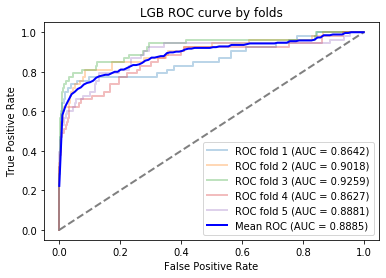

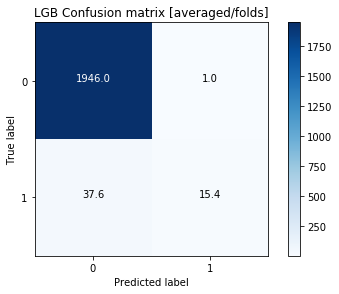

In [0]:
nfold = 5
skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=42)

oof = np.zeros(len(df_train))
mean_fpr = np.linspace(0,1,100)
cms= []
tprs = []
aucs = []
recalls = []
roc_aucs = []
f1_scores = []
accuracies = []
precisions = []
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

i = 1
for train_idx, valid_idx in skf.split(df_train, df_train.isFraud.values):
    print("\nfold {}".format(i))
    trn_data = lgb.Dataset(df_train.iloc[train_idx][features].values,
                                   label=df_train.iloc[train_idx][target].values
                                   )
    val_data = lgb.Dataset(df_train.iloc[valid_idx][features].values,
                                   label=df_train.iloc[valid_idx][target].values
                                   )   
    
    clf = lgb.train(param_lgb, trn_data, num_boost_round=800, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[valid_idx] = clf.predict(df_train.iloc[valid_idx][features].values) 
    
    predictions += clf.predict(df_test[features]) / nfold
    
    # Scores 
    roc_aucs.append(roc_auc_score(df_train.iloc[valid_idx][target].values, oof[valid_idx]))
    accuracies.append(accuracy_score(df_train.iloc[valid_idx][target].values, oof[valid_idx].round()))
    recalls.append(recall_score(df_train.iloc[valid_idx][target].values, oof[valid_idx].round()))
    precisions.append(precision_score(df_train.iloc[valid_idx][target].values ,oof[valid_idx].round()))
    f1_scores.append(f1_score(df_train.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Roc curve by fold
    fpr, tpr, t = roc_curve(df_train.iloc[valid_idx][target].values, oof[valid_idx])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (i,roc_auc))
    i= i+1
    
    # Confusion matrix by folds
    cms.append(confusion_matrix(df_train.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Features imp
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = nfold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# Metrics

roc_score  = np.mean(roc_aucs)
print(
        '\nCV roc score        : {0:.4f}, std: {1:.4f}.'.format(roc_score, np.std(roc_aucs)),
        '\nCV accuracy score   : {0:.4f}, std: {1:.4f}.'.format(np.mean(accuracies), np.std(accuracies)),
        '\nCV recall score     : {0:.4f}, std: {1:.4f}.'.format(np.mean(recalls), np.std(recalls)),
        '\nCV precision score  : {0:.4f}, std: {1:.4f}.'.format(np.mean(precisions), np.std(precisions)),
        '\nCV f1 score         : {0:.4f}, std: {1:.4f}.'.format(np.mean(f1_scores), np.std(f1_scores))
)

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.4f)' % (np.mean(roc_aucs)),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LGB ROC curve by folds')
plt.legend(loc="lower right")
plt.show()

# Confusion maxtrix & metrics
cm = np.average(cms, axis=0)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title= 'LGB Confusion matrix [averaged/folds]')
plt.show()

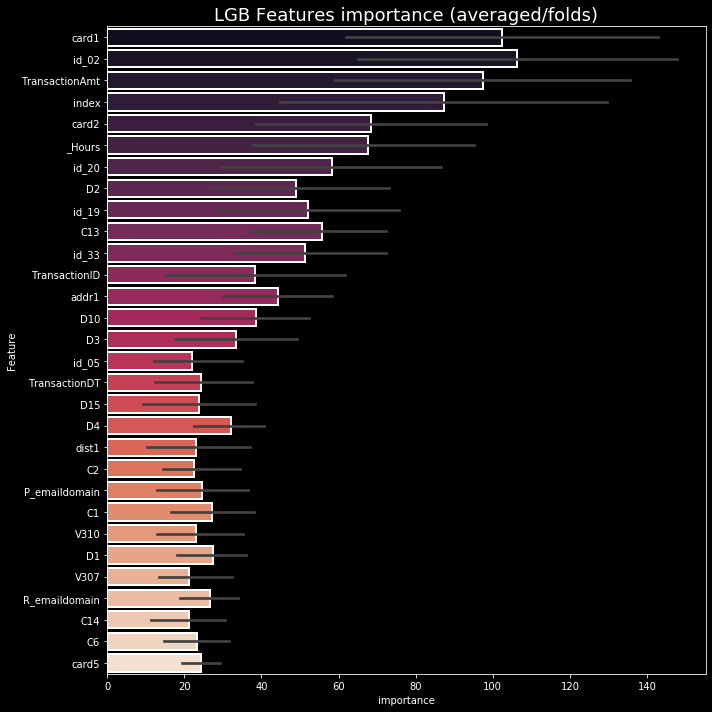

In [0]:


plt.style.use('dark_background')
cols = (feature_importance_df[["Feature", "importance"]]
    .groupby("Feature")
    .mean()
    .sort_values(by="importance", ascending=False)[:30].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(10,10))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False),
        edgecolor=('white'), linewidth=2, palette="rocket")
plt.title('LGB Features importance (averaged/folds)', fontsize=18)
plt.tight_layout()

